In [1]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import uuid
import sys
import scipy.stats 
import matplotlib
import itertools 
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os 

np.random.seed(0)
tf.set_random_seed(0)

NUMSTEPS = 20 #For printing and saving to tensorboard

NUMBATCHESTESTING = 100 #Number of batches for testing
UNIQUEID=  uuid.uuid1().__str__()[:6]
TENSORBOARDPATH = "tensorboard-layers-api/basic_" 
RESULTSFILEPATH = "results/basic_"
FIGPATH = "figures/basic_"+ UNIQUEID
TOPK = 5 #Collect top TOPK hyperparameters in separate file

#For representative sampling
MAXSTDREP = 4. #Maximum standard deviations for represntative sampling
NUMPOINTSX0 = 100 #Sampling for x0
NUMPOINTSZ = 100

In [2]:
############## 
#Helper functions
##############

def cartesian_product(*arrays): 
    return itertools.product(*arrays)


def tup_to_str(tups):
    cur_str = ""
    for k,tup in enumerate(tups):
        cur_str += str(tup)
        if k != len(tups)-1:
            cur_str+=','
    return cur_str

def variable_summaries(var_str, var):
    '''Attach a lot of summaries to a Tensor (for TensorBoard visualization).'''
    with tf.name_scope('summaries'):
#         mean = tf.reduce_mean(var)
#         tf.summary.scalar('mean', mean)
#         with tf.name_scope('stddev'):
#             stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
#         tf.summary.scalar('stddev', stddev)
#         tf.summary.scalar('max', tf.reduce_max(var))
#         tf.summary.scalar('min', tf.reduce_min(var))
#         tf.summary.histogram('histogram-'+var_str, var)
        tf.summary.scalar('norm_'+var_str, tf.norm(var))


In [3]:
def neural_net(param_string="", params={}, m=1, verbose=False):
    '''m: Dimension of x0 (default =1)
       param_string: String encoding information about hyperparameters
       
       params: parameter dictionary that contains
       num_batches: number of batches 
       batch_size: number of samples per batch
       sigma_x0: standard deviation of x0
       sigma_z: standard deviation of noise
       optimizer: the optimizer used to minimize cost
    '''
    tf.reset_default_graph()
  
    global_layer_num = 1

    #Learning rate and optimizer
    optimizer_function = params['optimizer_function']
    learning_rate = float(params['learning_rate'])

    #Placeholders for inputs
    x0 = tf.placeholder(tf.float32, [None, m])
    z = tf.placeholder(tf.float32, [None, m])
    adaptive_learning_rate = tf.placeholder_with_default(learning_rate, [])
    


    ###################################################
    #Layers
    #First we will go from x0 -> h1 via first layer structure 
    #Then we go from h1 -> u1 via second layer structure

    ####################################################

    #The layers   
    layer_structures  = params['layer_structures']
    ##########################        
    #First layer structure to get h1 from x0
    ##########################
    layer_structure = layer_structures[0]
    num_units = layer_structure[0]
    layer_activation = layer_structure[1]
    num_layers = layer_structure[2]
    net = x0 #Input to first layer of this structure
    for k in range(num_layers):
        net = tf.layers.dense(inputs=net, units=num_units, activation=layer_activation\
                              , use_bias=True, name = 'layer' + str(global_layer_num) )
        
        #Add to tensor board summary
        with tf.variable_scope('layer' + str(global_layer_num), reuse=True):
            with tf.name_scope('weights'):
                w = tf.get_variable('kernel')
                b = tf.get_variable('bias')
                variable_summaries('w'+str(global_layer_num), w)
                variable_summaries('b'+str(global_layer_num), b)

        global_layer_num += 1       
    h1 = net

    ############################        
    #Second layer structure to get x1 from h1
    ############################

    layer_structure = layer_structures[1]
    num_units = layer_structure[0]
    layer_activation = layer_structure[1]
    num_layers = layer_structure[2]
    net = h1 #Input to first layer of this structure
    for k in range(num_layers):
        net = tf.layers.dense(inputs=net, units=num_units, activation=layer_activation\
                               ,use_bias=True, name = 'layer' + str(global_layer_num))
        #Add to tensor board summary
        with tf.variable_scope('layer' + str(global_layer_num), reuse=True):
            with tf.name_scope('weights'):
                w = tf.get_variable('kernel')
                b = tf.get_variable('bias')
                variable_summaries('w'+str(global_layer_num), w)
                variable_summaries('b'+str(global_layer_num), b)
        global_layer_num += 1    
    u1 =net

    ################
    #Cost and optimizer
    
    x1 = x0 - u1
    y1 = x1 + z    
   
    cost = tf.reduce_mean(tf.reduce_mean((y1-1)**2,axis=1,keepdims = True))    
    optimizer = optimizer_function(adaptive_learning_rate).minimize(cost)

    ###################
    #Tensor board summary
    ####################
    tf.summary.scalar("cost", cost)
    tf.summary.scalar("adaptive_learning_rate", adaptive_learning_rate)
    merged_summary_op = tf.summary.merge_all()   



    ######################################
    #Session
    #####################################
    with tf.Session() as sess:

        #Creates/saves in directory named tensorboard-layers-api in same directory as the .ipynb
        uniq_id = TENSORBOARDPATH +  UNIQUEID +"/" + param_string
        summary_writer = tf.summary.FileWriter(uniq_id, graph=tf.get_default_graph())


        #######################################
        #Training
        #Train the nn on training set constructed by sampling x0 and z independently from gaussian
        #distributions with means 0 and standard deviations sigma_x0 and sigma_z respectively
        #######################################

        if verbose is True:
            print("Training...")

        #Initialization
        init_op = tf.global_variables_initializer()
        sess.run(init_op) 

        batch_size = params['batch_size']
        sigma_x0 = params['sigma_x0']
        sigma_z = params['sigma_z']
        max_epochs = params['max_epochs']
        learning_rate_decay= float(params['learning_rate_decay'])

        step_size= np.ceil(max_epochs/NUMSTEPS) #For printing and saving to tensor board

        ''''''
        #WARNING: Can only be used when marginals along dimensions are independent 
        train_costs = np.zeros((max_epochs,1))
        for step in range(max_epochs): #Splitting into multiple batches so as to not run into memory issues
            batch_x0 = np.random.normal(loc=np.zeros((m,)), scale = sigma_x0, size=[batch_size,m])
            batch_z = np.random.normal(loc=np.zeros((m,)), scale = sigma_z, size=[batch_size,m])


            #Adaptive learning rate 
            cur_adaptive_learning_rate = learning_rate*float(learning_rate_decay**step)


            _,batch_cost,summary = sess.run([optimizer,cost,merged_summary_op],\
       
                        feed_dict = {x0:batch_x0, z:batch_z, adaptive_learning_rate:cur_adaptive_learning_rate\
                                    })
            train_costs[step] = batch_cost

            if step % step_size == 0: 
                summary_writer.add_summary(summary, step)
                if verbose is True:
                    print("---Step: {}, Cost: {}".format(step,batch_cost))

        ######################################
        #Testing on sampled Gaussians
        #Evaluate the nn on test set constructed by sampling x0 and z independently from gaussian
        #distributions  with means 0 and standard deviations sigma_x0 and sigma_z respectively            
        ######################################################
        if verbose is True:
            print("Evaluating on sampled gaussians...")
        num_batches = params['num_batches']
        batch_size = params['batch_size']
        sigma_x0 = params['sigma_x0']
        sigma_z = params['sigma_z']
        ''''''
        #WARNING: Can only be used when marginals along dimensions are independent 
        test_costs = np.zeros((num_batches,1))
        for i in range(num_batches): #Splitting into multiple batches so as to not run into memory issues
            batch_x0 = np.random.normal(loc=np.zeros((m,)), scale = sigma_x0, size=[batch_size,m])
            batch_z = np.random.normal(loc=np.zeros((m,)), scale = sigma_z, size=[batch_size,m])

            batch_cost = sess.run(cost, feed_dict = {x0:batch_x0, z:batch_z})
            test_costs[i] = batch_cost
            if verbose is True:
                if i % step_size == 0:
                    print("---Batch: {}, Cost: {}".format(i,batch_cost))

        avg_test_cost = float(np.mean(test_costs, axis = 0))
        if verbose is True:
            print("Average test cost: {}".format(avg_test_cost))
        
       ##########################################
        ###Test over representative x0 and z landscape
       #################################################
        if verbose is True:
            print("Evaluating on representative samples...")
        sigma_x0 = params['sigma_x0']
        sigma_z = params['sigma_z']
        
        sigma_x0 = params['sigma_x0']
        sigma_z = params['sigma_z']

        #WARNING:CODE will work only for m = 1
        x0_test_rep = np.linspace(-MAXSTDREP*sigma_x0, MAXSTDREP*sigma_x0, num=NUMPOINTSX0)
        z_test_rep = np.linspace(-MAXSTDREP*sigma_z, MAXSTDREP*sigma_z, num=NUMPOINTSZ)

        x0_distribution = scipy.stats.norm(loc=0., scale=sigma_x0)
        z_distribution = scipy.stats.norm(loc = 0., scale = sigma_z)

        x0_pdf= x0_distribution.pdf(x0_test_rep)
        z_pdf = z_distribution.pdf(z_test_rep)


        test_costs_rep = np.zeros((NUMPOINTSX0, NUMPOINTSZ))
        u1_test_rep_2d = np.zeros((NUMPOINTSX0, NUMPOINTSZ))
        
        
        total_density = 0.
        for i in range(NUMPOINTSX0):
            for j in range(NUMPOINTSZ):
                cur_density = x0_pdf[i]*z_pdf[j]
                total_density += cur_density
                
                raw_cost,cur_u1 = sess.run([cost,u1], feed_dict = {x0:np.reshape(x0_test_rep[i],[-1,1]),\
                                                   z:np.reshape(z_test_rep[j] ,[-1,1])})
                scaled_cost = raw_cost*cur_density
                
                test_costs_rep[i,j] = scaled_cost
               
                u1_test_rep_2d[i,j] = cur_u1*z_pdf[j]
                               
        avg_test_cost_rep = np.sum(test_costs_rep/total_density)
        u1_test_rep = np.sum(u1_test_rep_2d, axis = 1)/np.sum(z_pdf)
        
        
        
        if verbose is True:
            print("Average test cost rep: {}".format(avg_test_cost_rep))     
        

            
        return avg_test_cost, avg_test_cost_rep, x0_test_rep, u1_test_rep


In [4]:
       
#######
#Cartesian product to get the layer structures
######
#First find tuples for different types of layers

hidden_units_type1 = [5,10]
hidden_units_type1_str= ['5','10']
activations_type1 = [tf.nn.sigmoid, None]
activations_type1_str = ['sigmoid', 'linear']


# activations_type1 = [tf.nn.sigmoid]
# activations_type1_str = ['sigmoid']

num_layers_type1 = [1]
num_layers_type1_str = ['1']


hidden_units_type2 = [1]
hidden_units_type2_str= ['1']
activations_type2 = [tf.identity]
activations_type2_str = ['identity']
num_layers_type2= [1]
num_layers_type2_str = ['1']

layers_type1 = cartesian_product(hidden_units_type1, activations_type1, num_layers_type1)
layers_type1_str = ['ls1_' + tup_to_str(tup) for tup in cartesian_product(hidden_units_type1_str, activations_type1_str, num_layers_type1_str)]


layers_type2 = cartesian_product(hidden_units_type2, activations_type2, num_layers_type2)
layers_type2_str = ['ls2_'+tup_to_str(tup) for tup in cartesian_product(hidden_units_type2_str, activations_type2_str, num_layers_type2_str)]


layers = cartesian_product(layers_type1, layers_type2)
layers_str = [tup_to_str(tup) for tup in cartesian_product(layers_type1_str, layers_type2_str)]

#Next find tuples for the whole parameter space
k_squared_vals = [1.]
k_squared_vals_str = ['k_'+str(elem) for elem in k_squared_vals]
learning_rates = [0.1, 0.01, 1., 10., 100.]
learning_rates_str = ['lr_'+str(elem) for elem in learning_rates]
learning_rate_decays = [1.-1e-9]
learning_rate_decays_str = ['lrd_1-1e-9']
max_epochs = [100]
max_epochs_str = ['me_' + str(elem) for elem in max_epochs]
batch_sizes = [10000]
batch_sizes_str = ['bsz_' +str(elem) for elem in batch_sizes]
sigmas_x0 = [2.]
sigmas_x0_str = ['stdx0_' +str(elem) for elem in sigmas_x0]
sigmas_z = [1.]
sigmas_z_str = ['stdz_' +str(elem) for elem in sigmas_z]

optimizer_functions = [tf.train.AdamOptimizer]
optimizer_functions_str = ['Adam']


hyperparam_tuples = list(cartesian_product(layers, k_squared_vals, learning_rates, learning_rate_decays,\
                                           max_epochs, batch_sizes, sigmas_x0, sigmas_z, optimizer_functions))
hyperparam_tuples_str = [tup_to_str(tup) for tup in list(cartesian_product(layers_str, k_squared_vals_str,\
                                                learning_rates_str, learning_rate_decays_str, max_epochs_str,\
                                        batch_sizes_str, sigmas_x0_str, sigmas_z_str, optimizer_functions_str))]

        


In [5]:
%matplotlib inline
##################
#Main Loop
##################
hyperparam_results_list = []
for k,tup in enumerate(tqdm(hyperparam_tuples)):
    
    layer_structure = tup[0]
    k_squared = tup[1]
    learning_rate = tup[2]
    learning_rate_decay = tup[3]
    max_epoch = tup[4]
    batch_size = tup[5]
    sigma_x0 = tup[6]
    sigma_z = tup[7]
    optimizer_function = tup[8]
    
    tup_str = hyperparam_tuples_str[k]
    params = {'num_batches':NUMBATCHESTESTING, 'batch_size':batch_size, 'sigma_x0':sigma_x0, 'sigma_z':sigma_z,\
              'optimizer_function':optimizer_function, 'learning_rate':learning_rate, 'max_epochs':max_epoch,\
              'learning_rate_decay':learning_rate_decay, 'layer_structures':layer_structure}
    
    print(tup_str)
    avg_test_cost, avg_test_cost_rep, x0_test_rep, u1_test_rep = \
    neural_net(param_string= tup_str, params=params, verbose = True)   
    
   
    hyperparam_results_list.append([tup_str,avg_test_cost, avg_test_cost_rep, x0_test_rep, u1_test_rep])
    results_file = RESULTSFILEPATH + UNIQUEID + '.txt'
    with open(results_file, 'a') as f:
      f.write(tup_str + " " + str(avg_test_cost) + " " + str(avg_test_cost_rep) + '\n')
      f.close()

  0%|          | 0/20 [00:00<?, ?it/s]

ls1_5,sigmoid,1,ls2_1,identity,1,k_1.0,lr_0.1,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 8.227119445800781
---Step: 5, Cost: 4.515496730804443
---Step: 10, Cost: 2.957901954650879
---Step: 15, Cost: 2.115867853164673
---Step: 20, Cost: 1.6724272966384888
---Step: 25, Cost: 1.640332579612732
---Step: 30, Cost: 1.689450740814209
---Step: 35, Cost: 1.4901692867279053
---Step: 40, Cost: 1.332643985748291
---Step: 45, Cost: 1.3856778144836426
---Step: 50, Cost: 1.266457438468933
---Step: 55, Cost: 1.1720901727676392
---Step: 60, Cost: 1.1422381401062012
---Step: 65, Cost: 1.105323076248169
---Step: 70, Cost: 1.0944851636886597
---Step: 75, Cost: 1.0469577312469482
---Step: 80, Cost: 1.01003897190094
---Step: 85, Cost: 1.0231046676635742
---Step: 90, Cost: 1.0324980020523071
---Step: 95, Cost: 1.0420771837234497
Evaluating on sampled gaussians...
---Batch: 0, Cost: 1.0287697315216064
---Batch: 5, Cost: 1.0147922039031982
---Batch: 10, Cost: 1.0415971279

  5%|▌         | 1/20 [00:02<00:49,  2.63s/it]

Average test cost rep: 1.021158419317749
ls1_5,sigmoid,1,ls2_1,identity,1,k_1.0,lr_0.01,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 5.651767253875732
---Step: 5, Cost: 5.272230625152588
---Step: 10, Cost: 4.5909810066223145
---Step: 15, Cost: 4.198437690734863
---Step: 20, Cost: 3.833679676055908
---Step: 25, Cost: 3.53452730178833
---Step: 30, Cost: 3.1492013931274414
---Step: 35, Cost: 2.8328840732574463
---Step: 40, Cost: 2.607192039489746
---Step: 45, Cost: 2.4046874046325684
---Step: 50, Cost: 2.1591732501983643
---Step: 55, Cost: 2.085618257522583
---Step: 60, Cost: 1.8907667398452759
---Step: 65, Cost: 1.777091383934021
---Step: 70, Cost: 1.6569523811340332
---Step: 75, Cost: 1.6341267824172974
---Step: 80, Cost: 1.5831595659255981
---Step: 85, Cost: 1.5146597623825073
---Step: 90, Cost: 1.4094775915145874
---Step: 95, Cost: 1.4192782640457153
Evaluating on sampled gaussians...
---Batch: 0, Cost: 1.437021017074585
---Batch: 5, Cost: 1.384203

 10%|█         | 2/20 [00:05<00:47,  2.64s/it]

Average test cost rep: 1.4053412062608333
ls1_5,sigmoid,1,ls2_1,identity,1,k_1.0,lr_1.0,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 6.0838093757629395
---Step: 5, Cost: 2.7506160736083984
---Step: 10, Cost: 1.7940083742141724
---Step: 15, Cost: 1.2528982162475586
---Step: 20, Cost: 1.3397353887557983
---Step: 25, Cost: 1.2391338348388672
---Step: 30, Cost: 1.1546285152435303
---Step: 35, Cost: 1.1359519958496094
---Step: 40, Cost: 1.0981069803237915
---Step: 45, Cost: 1.0557682514190674
---Step: 50, Cost: 1.0304460525512695
---Step: 55, Cost: 1.0436302423477173
---Step: 60, Cost: 1.0302870273590088
---Step: 65, Cost: 1.0732107162475586
---Step: 70, Cost: 1.0534056425094604
---Step: 75, Cost: 1.0413209199905396
---Step: 80, Cost: 1.0570461750030518
---Step: 85, Cost: 1.047013521194458
---Step: 90, Cost: 0.9965090751647949
---Step: 95, Cost: 0.9991123080253601
Evaluating on sampled gaussians...
---Batch: 0, Cost: 1.0678927898406982
---Batch: 5, Cost:

 15%|█▌        | 3/20 [00:07<00:44,  2.64s/it]

Average test cost rep: 1.0383434330663397
ls1_5,sigmoid,1,ls2_1,identity,1,k_1.0,lr_10.0,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 7.136523246765137
---Step: 5, Cost: 202.57525634765625
---Step: 10, Cost: 49.82632064819336
---Step: 15, Cost: 10.162219047546387
---Step: 20, Cost: 22.698896408081055
---Step: 25, Cost: 13.141437530517578
---Step: 30, Cost: 3.3947057723999023
---Step: 35, Cost: 6.927892208099365
---Step: 40, Cost: 5.618142127990723
---Step: 45, Cost: 3.0045511722564697
---Step: 50, Cost: 3.146249532699585
---Step: 55, Cost: 3.5181734561920166
---Step: 60, Cost: 3.3158419132232666
---Step: 65, Cost: 2.8613312244415283
---Step: 70, Cost: 2.9518940448760986
---Step: 75, Cost: 2.8684206008911133
---Step: 80, Cost: 2.8460824489593506
---Step: 85, Cost: 2.7470242977142334
---Step: 90, Cost: 2.846142292022705
---Step: 95, Cost: 2.7829506397247314
Evaluating on sampled gaussians...
---Batch: 0, Cost: 2.771571397781372
---Batch: 5, Cost: 2.81

 20%|██        | 4/20 [00:10<00:41,  2.62s/it]

Average test cost rep: 2.721668402194073
ls1_5,sigmoid,1,ls2_1,identity,1,k_1.0,lr_100.0,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 3.7771406173706055
---Step: 5, Cost: 15859.42578125
---Step: 10, Cost: 2749.2373046875
---Step: 15, Cost: 7266.41748046875
---Step: 20, Cost: 397.119384765625
---Step: 25, Cost: 1611.4267578125
---Step: 30, Cost: 373.5184020996094
---Step: 35, Cost: 608.2133178710938
---Step: 40, Cost: 58.878875732421875
---Step: 45, Cost: 164.91529846191406
---Step: 50, Cost: 49.8486213684082
---Step: 55, Cost: 79.45639038085938
---Step: 60, Cost: 14.981849670410156
---Step: 65, Cost: 25.19690704345703
---Step: 70, Cost: 9.759352684020996
---Step: 75, Cost: 10.968937873840332
---Step: 80, Cost: 2.767160654067993
---Step: 85, Cost: 5.404873847961426
---Step: 90, Cost: 3.4019625186920166
---Step: 95, Cost: 2.43721866607666
Evaluating on sampled gaussians...
---Batch: 0, Cost: 2.525087833404541
---Batch: 5, Cost: 2.642554759979248
---Ba

 25%|██▌       | 5/20 [00:13<00:39,  2.60s/it]

Average test cost rep: 2.5469490015067784
ls1_5,linear,1,ls2_1,identity,1,k_1.0,lr_0.1,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 7.893346786499023
---Step: 5, Cost: 1.4815177917480469
---Step: 10, Cost: 1.0062204599380493
---Step: 15, Cost: 1.2328146696090698
---Step: 20, Cost: 1.2373263835906982
---Step: 25, Cost: 1.0677199363708496
---Step: 30, Cost: 1.0228279829025269
---Step: 35, Cost: 1.053670883178711
---Step: 40, Cost: 1.018246054649353
---Step: 45, Cost: 0.9901124835014343
---Step: 50, Cost: 1.0099279880523682
---Step: 55, Cost: 1.0249927043914795
---Step: 60, Cost: 1.014078140258789
---Step: 65, Cost: 0.9668288230895996
---Step: 70, Cost: 1.0060503482818604
---Step: 75, Cost: 0.997614860534668
---Step: 80, Cost: 0.9532650113105774
---Step: 85, Cost: 0.9871681928634644
---Step: 90, Cost: 0.9715874791145325
---Step: 95, Cost: 1.0030262470245361
Evaluating on sampled gaussians...
---Batch: 0, Cost: 1.0013799667358398
---Batch: 5, Cost: 1.00

 30%|███       | 6/20 [00:15<00:36,  2.58s/it]

Average test cost rep: 0.9994865252313478
ls1_5,linear,1,ls2_1,identity,1,k_1.0,lr_0.01,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 12.082741737365723
---Step: 5, Cost: 9.142675399780273
---Step: 10, Cost: 6.6488471031188965
---Step: 15, Cost: 4.754855632781982
---Step: 20, Cost: 3.2129483222961426
---Step: 25, Cost: 2.0537033081054688
---Step: 30, Cost: 1.4171501398086548
---Step: 35, Cost: 1.0626540184020996
---Step: 40, Cost: 1.0183537006378174
---Step: 45, Cost: 1.043358564376831
---Step: 50, Cost: 1.0860695838928223
---Step: 55, Cost: 1.0430346727371216
---Step: 60, Cost: 1.0100244283676147
---Step: 65, Cost: 1.020897388458252
---Step: 70, Cost: 1.0109034776687622
---Step: 75, Cost: 0.9941046833992004
---Step: 80, Cost: 1.015634298324585
---Step: 85, Cost: 1.0131120681762695
---Step: 90, Cost: 0.9951164126396179
---Step: 95, Cost: 1.004075288772583
Evaluating on sampled gaussians...
---Batch: 0, Cost: 0.9833280444145203
---Batch: 5, Cost: 1.01

 35%|███▌      | 7/20 [00:18<00:33,  2.58s/it]

Average test cost rep: 0.9992126764369755
ls1_5,linear,1,ls2_1,identity,1,k_1.0,lr_1.0,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 2.7054624557495117
---Step: 5, Cost: 3.204777240753174
---Step: 10, Cost: 7.902982711791992
---Step: 15, Cost: 9.91790771484375
---Step: 20, Cost: 1.1040269136428833
---Step: 25, Cost: 4.008883476257324
---Step: 30, Cost: 3.3202085494995117
---Step: 35, Cost: 1.8065017461776733
---Step: 40, Cost: 1.731782078742981
---Step: 45, Cost: 1.5621631145477295
---Step: 50, Cost: 1.2655916213989258
---Step: 55, Cost: 1.1786842346191406
---Step: 60, Cost: 1.0456286668777466
---Step: 65, Cost: 1.0328809022903442
---Step: 70, Cost: 1.0265159606933594
---Step: 75, Cost: 1.001808762550354
---Step: 80, Cost: 0.9949726462364197
---Step: 85, Cost: 1.003153920173645
---Step: 90, Cost: 0.9859970808029175
---Step: 95, Cost: 1.0167808532714844
Evaluating on sampled gaussians...
---Batch: 0, Cost: 1.0612545013427734
---Batch: 5, Cost: 1.05037

 40%|████      | 8/20 [00:20<00:30,  2.56s/it]

Average test cost rep: 1.0513585063885789
ls1_5,linear,1,ls2_1,identity,1,k_1.0,lr_10.0,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 2.0143823623657227
---Step: 5, Cost: 321813.75
---Step: 10, Cost: 6763.20947265625
---Step: 15, Cost: 26541.111328125
---Step: 20, Cost: 16405.4375
---Step: 25, Cost: 8193.220703125
---Step: 30, Cost: 11266.701171875
---Step: 35, Cost: 424.85919189453125
---Step: 40, Cost: 798.8980102539062
---Step: 45, Cost: 299.1317138671875
---Step: 50, Cost: 46.283668518066406
---Step: 55, Cost: 234.87484741210938
---Step: 60, Cost: 165.88095092773438
---Step: 65, Cost: 9.778524398803711
---Step: 70, Cost: 23.0059871673584
---Step: 75, Cost: 39.697418212890625
---Step: 80, Cost: 12.737213134765625
---Step: 85, Cost: 1.4794939756393433
---Step: 90, Cost: 5.533156394958496
---Step: 95, Cost: 5.6441826820373535
Evaluating on sampled gaussians...
---Batch: 0, Cost: 1.7687978744506836
---Batch: 5, Cost: 1.7164665460586548
---Batch: 10, 

 45%|████▌     | 9/20 [00:22<00:28,  2.55s/it]

Average test cost rep: 1.7756369779726564
ls1_5,linear,1,ls2_1,identity,1,k_1.0,lr_100.0,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 4.703881740570068
---Step: 5, Cost: 2273516288.0
---Step: 10, Cost: 601579520.0
---Step: 15, Cost: 1229768704.0
---Step: 20, Cost: 1063634688.0
---Step: 25, Cost: 454614016.0
---Step: 30, Cost: 12840736.0
---Step: 35, Cost: 152575696.0
---Step: 40, Cost: 49050352.0
---Step: 45, Cost: 258457.5
---Step: 50, Cost: 10944314.0
---Step: 55, Cost: 14727764.0
---Step: 60, Cost: 9713916.0
---Step: 65, Cost: 4581184.0
---Step: 70, Cost: 1427630.125
---Step: 75, Cost: 201097.5
---Step: 80, Cost: 19384.59765625
---Step: 85, Cost: 197534.96875
---Step: 90, Cost: 312683.34375
---Step: 95, Cost: 248581.21875
Evaluating on sampled gaussians...
---Batch: 0, Cost: 102652.6796875
---Batch: 5, Cost: 102470.375
---Batch: 10, Cost: 103783.5078125
---Batch: 15, Cost: 104026.6953125
---Batch: 20, Cost: 102418.0390625
---Batch: 25, Cost: 1038

 50%|█████     | 10/20 [00:25<00:25,  2.53s/it]

Average test cost rep: 101445.32887756424
ls1_10,sigmoid,1,ls2_1,identity,1,k_1.0,lr_0.1,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 8.645384788513184
---Step: 5, Cost: 4.04730224609375
---Step: 10, Cost: 2.5628902912139893
---Step: 15, Cost: 1.4986857175827026
---Step: 20, Cost: 1.6101224422454834
---Step: 25, Cost: 1.602065086364746
---Step: 30, Cost: 1.366790533065796
---Step: 35, Cost: 1.394377589225769
---Step: 40, Cost: 1.2219511270523071
---Step: 45, Cost: 1.1674373149871826
---Step: 50, Cost: 1.166651964187622
---Step: 55, Cost: 1.107986569404602
---Step: 60, Cost: 1.0676229000091553
---Step: 65, Cost: 1.0800124406814575
---Step: 70, Cost: 1.030038833618164
---Step: 75, Cost: 1.0470187664031982
---Step: 80, Cost: 1.0252535343170166
---Step: 85, Cost: 0.9960156083106995
---Step: 90, Cost: 1.0181320905685425
---Step: 95, Cost: 0.9934406280517578
Evaluating on sampled gaussians...
---Batch: 0, Cost: 0.9921706914901733
---Batch: 5, Cost: 1.0154

 55%|█████▌    | 11/20 [00:27<00:22,  2.52s/it]

Average test cost rep: 1.0125787761854133
ls1_10,sigmoid,1,ls2_1,identity,1,k_1.0,lr_0.01,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 6.398109436035156
---Step: 5, Cost: 5.622529983520508
---Step: 10, Cost: 5.014758110046387
---Step: 15, Cost: 4.421841621398926
---Step: 20, Cost: 3.8481006622314453
---Step: 25, Cost: 3.373274326324463
---Step: 30, Cost: 2.959707260131836
---Step: 35, Cost: 2.6099460124969482
---Step: 40, Cost: 2.256645917892456
---Step: 45, Cost: 1.9604970216751099
---Step: 50, Cost: 1.745698094367981
---Step: 55, Cost: 1.5202616453170776
---Step: 60, Cost: 1.434022307395935
---Step: 65, Cost: 1.3223587274551392
---Step: 70, Cost: 1.2618175745010376
---Step: 75, Cost: 1.2545493841171265
---Step: 80, Cost: 1.2129478454589844
---Step: 85, Cost: 1.1898211240768433
---Step: 90, Cost: 1.2027324438095093
---Step: 95, Cost: 1.1826887130737305
Evaluating on sampled gaussians...
---Batch: 0, Cost: 1.2149863243103027
---Batch: 5, Cost: 1.196

 60%|██████    | 12/20 [00:30<00:20,  2.52s/it]

Average test cost rep: 1.190527355194966
ls1_10,sigmoid,1,ls2_1,identity,1,k_1.0,lr_1.0,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 8.915594100952148
---Step: 5, Cost: 4.609293460845947
---Step: 10, Cost: 2.7966151237487793
---Step: 15, Cost: 2.22765851020813
---Step: 20, Cost: 1.7840404510498047
---Step: 25, Cost: 1.5976002216339111
---Step: 30, Cost: 1.3837298154830933
---Step: 35, Cost: 1.3177040815353394
---Step: 40, Cost: 1.22722327709198
---Step: 45, Cost: 1.1962114572525024
---Step: 50, Cost: 1.1466474533081055
---Step: 55, Cost: 1.1158556938171387
---Step: 60, Cost: 1.0782661437988281
---Step: 65, Cost: 1.0849816799163818
---Step: 70, Cost: 1.1122910976409912
---Step: 75, Cost: 1.0612003803253174
---Step: 80, Cost: 1.0348886251449585
---Step: 85, Cost: 1.050182580947876
---Step: 90, Cost: 1.0254247188568115
---Step: 95, Cost: 1.0316274166107178
Evaluating on sampled gaussians...
---Batch: 0, Cost: 1.0079578161239624
---Batch: 5, Cost: 1.047

 65%|██████▌   | 13/20 [00:32<00:17,  2.51s/it]

Average test cost rep: 1.0109016793584518
ls1_10,sigmoid,1,ls2_1,identity,1,k_1.0,lr_10.0,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 6.206042289733887
---Step: 5, Cost: 520.617919921875
---Step: 10, Cost: 158.62026977539062
---Step: 15, Cost: 118.51730346679688
---Step: 20, Cost: 19.92776870727539
---Step: 25, Cost: 34.236106872558594
---Step: 30, Cost: 6.626840591430664
---Step: 35, Cost: 12.242507934570312
---Step: 40, Cost: 5.487737655639648
---Step: 45, Cost: 4.245107650756836
---Step: 50, Cost: 4.135411739349365
---Step: 55, Cost: 1.6150362491607666
---Step: 60, Cost: 2.17846941947937
---Step: 65, Cost: 1.899424433708191
---Step: 70, Cost: 1.3968790769577026
---Step: 75, Cost: 1.462314248085022
---Step: 80, Cost: 1.4431068897247314
---Step: 85, Cost: 1.3666070699691772
---Step: 90, Cost: 1.3684757947921753
---Step: 95, Cost: 1.3330427408218384
Evaluating on sampled gaussians...
---Batch: 0, Cost: 1.280136227607727
---Batch: 5, Cost: 1.3199473

 70%|███████   | 14/20 [00:35<00:15,  2.51s/it]

Average test cost rep: 1.3255340847241777
ls1_10,sigmoid,1,ls2_1,identity,1,k_1.0,lr_100.0,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 8.379129409790039
---Step: 5, Cost: 78226.9453125
---Step: 10, Cost: 13912.927734375
---Step: 15, Cost: 3742.652099609375
---Step: 20, Cost: 8661.662109375
---Step: 25, Cost: 781.337158203125
---Step: 30, Cost: 2162.451171875
---Step: 35, Cost: 1146.1851806640625
---Step: 40, Cost: 222.72189331054688
---Step: 45, Cost: 781.7363891601562
---Step: 50, Cost: 95.2263412475586
---Step: 55, Cost: 139.49839782714844
---Step: 60, Cost: 142.51942443847656
---Step: 65, Cost: 9.241915702819824
---Step: 70, Cost: 30.340822219848633
---Step: 75, Cost: 33.40636444091797
---Step: 80, Cost: 6.486701488494873
---Step: 85, Cost: 5.567302227020264
---Step: 90, Cost: 9.053261756896973
---Step: 95, Cost: 5.4319305419921875
Evaluating on sampled gaussians...
---Batch: 0, Cost: 2.593442440032959
---Batch: 5, Cost: 2.6104111671447754
---Ba

 75%|███████▌  | 15/20 [00:37<00:12,  2.53s/it]

Average test cost rep: 2.5885745338621047
ls1_10,linear,1,ls2_1,identity,1,k_1.0,lr_0.1,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 12.766545295715332
---Step: 5, Cost: 3.292569637298584
---Step: 10, Cost: 1.8979015350341797
---Step: 15, Cost: 1.1721291542053223
---Step: 20, Cost: 1.1975040435791016
---Step: 25, Cost: 1.1736260652542114
---Step: 30, Cost: 1.035893201828003
---Step: 35, Cost: 1.0401840209960938
---Step: 40, Cost: 1.0349855422973633
---Step: 45, Cost: 1.0072414875030518
---Step: 50, Cost: 1.016334891319275
---Step: 55, Cost: 1.0125986337661743
---Step: 60, Cost: 1.0046935081481934
---Step: 65, Cost: 0.997361421585083
---Step: 70, Cost: 0.9998794794082642
---Step: 75, Cost: 0.9776753187179565
---Step: 80, Cost: 0.9871497750282288
---Step: 85, Cost: 0.9998788237571716
---Step: 90, Cost: 0.9963374733924866
---Step: 95, Cost: 1.0020371675491333
Evaluating on sampled gaussians...
---Batch: 0, Cost: 0.9772721529006958
---Batch: 5, Cost: 0.

 80%|████████  | 16/20 [00:40<00:10,  2.53s/it]

Average test cost rep: 0.9992431080160689
ls1_10,linear,1,ls2_1,identity,1,k_1.0,lr_0.01,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 12.360899925231934
---Step: 5, Cost: 8.393691062927246
---Step: 10, Cost: 5.676997661590576
---Step: 15, Cost: 3.454732894897461
---Step: 20, Cost: 2.025357723236084
---Step: 25, Cost: 1.1867905855178833
---Step: 30, Cost: 1.0249098539352417
---Step: 35, Cost: 1.0717636346817017
---Step: 40, Cost: 1.140726923942566
---Step: 45, Cost: 1.095575213432312
---Step: 50, Cost: 1.0384681224822998
---Step: 55, Cost: 1.0201175212860107
---Step: 60, Cost: 0.9957168698310852
---Step: 65, Cost: 1.024489402770996
---Step: 70, Cost: 0.981027364730835
---Step: 75, Cost: 0.9968185424804688
---Step: 80, Cost: 1.009413242340088
---Step: 85, Cost: 0.9908523559570312
---Step: 90, Cost: 1.018744945526123
---Step: 95, Cost: 1.0131287574768066
Evaluating on sampled gaussians...
---Batch: 0, Cost: 0.9863256812095642
---Batch: 5, Cost: 1.00900

 85%|████████▌ | 17/20 [00:42<00:07,  2.52s/it]

Average test cost rep: 0.9993063224854154
ls1_10,linear,1,ls2_1,identity,1,k_1.0,lr_1.0,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 2.542123794555664
---Step: 5, Cost: 7.007688999176025
---Step: 10, Cost: 32.973751068115234
---Step: 15, Cost: 20.543649673461914
---Step: 20, Cost: 2.3903510570526123
---Step: 25, Cost: 14.144220352172852
---Step: 30, Cost: 8.194098472595215
---Step: 35, Cost: 1.2453044652938843
---Step: 40, Cost: 3.575798749923706
---Step: 45, Cost: 1.6283600330352783
---Step: 50, Cost: 1.656067132949829
---Step: 55, Cost: 1.4770606756210327
---Step: 60, Cost: 1.0590237379074097
---Step: 65, Cost: 1.263594388961792
---Step: 70, Cost: 1.0428550243377686
---Step: 75, Cost: 1.0852117538452148
---Step: 80, Cost: 1.0438551902770996
---Step: 85, Cost: 1.0128241777420044
---Step: 90, Cost: 1.0227429866790771
---Step: 95, Cost: 1.025030255317688
Evaluating on sampled gaussians...
---Batch: 0, Cost: 1.0178351402282715
---Batch: 5, Cost: 0.971

 90%|█████████ | 18/20 [00:45<00:05,  2.52s/it]

Average test cost rep: 1.002215572881314
ls1_10,linear,1,ls2_1,identity,1,k_1.0,lr_10.0,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 10.854241371154785
---Step: 5, Cost: 886204.3125
---Step: 10, Cost: 38094.88671875
---Step: 15, Cost: 197438.15625
---Step: 20, Cost: 8863.2451171875
---Step: 25, Cost: 1757.7979736328125
---Step: 30, Cost: 29907.544921875
---Step: 35, Cost: 65813.0234375
---Step: 40, Cost: 49708.796875
---Step: 45, Cost: 2488.4833984375
---Step: 50, Cost: 14688.4755859375
---Step: 55, Cost: 1881.0140380859375
---Step: 60, Cost: 8946.1953125
---Step: 65, Cost: 3976.63671875
---Step: 70, Cost: 891.9299926757812
---Step: 75, Cost: 540.8002319335938
---Step: 80, Cost: 1876.65478515625
---Step: 85, Cost: 2583.231689453125
---Step: 90, Cost: 2787.510498046875
---Step: 95, Cost: 3295.124755859375
Evaluating on sampled gaussians...
---Batch: 0, Cost: 58027.69140625
---Batch: 5, Cost: 56074.11328125
---Batch: 10, Cost: 57076.47265625
---Batch:

 95%|█████████▌| 19/20 [00:47<00:02,  2.52s/it]

Average test cost rep: 57567.165158791075
ls1_10,linear,1,ls2_1,identity,1,k_1.0,lr_100.0,lrd_1-1e-9,me_100,bsz_10000,stdx0_2.0,stdz_1.0,Adam
Training...
---Step: 0, Cost: 7.806737422943115
---Step: 5, Cost: 25814163456.0
---Step: 10, Cost: 716437760.0
---Step: 15, Cost: 5540696576.0
---Step: 20, Cost: 1904515968.0
---Step: 25, Cost: 1478442624.0
---Step: 30, Cost: 469319456.0
---Step: 35, Cost: 1474840448.0
---Step: 40, Cost: 745730880.0
---Step: 45, Cost: 245649376.0
---Step: 50, Cost: 74498928.0
---Step: 55, Cost: 75313800.0
---Step: 60, Cost: 116667608.0
---Step: 65, Cost: 119646872.0
---Step: 70, Cost: 28633022.0
---Step: 75, Cost: 5505943.0
---Step: 80, Cost: 25093382.0
---Step: 85, Cost: 652859.8125
---Step: 90, Cost: 8287866.0
---Step: 95, Cost: 6322325.5
Evaluating on sampled gaussians...
---Batch: 0, Cost: 1250998.625
---Batch: 5, Cost: 1279038.5
---Batch: 10, Cost: 1274269.75
---Batch: 15, Cost: 1257658.375
---Batch: 20, Cost: 1297256.5
---Batch: 25, Cost: 1258114.125
---Bat

100%|██████████| 20/20 [00:50<00:00,  2.52s/it]

Average test cost rep: 1268607.2384660777


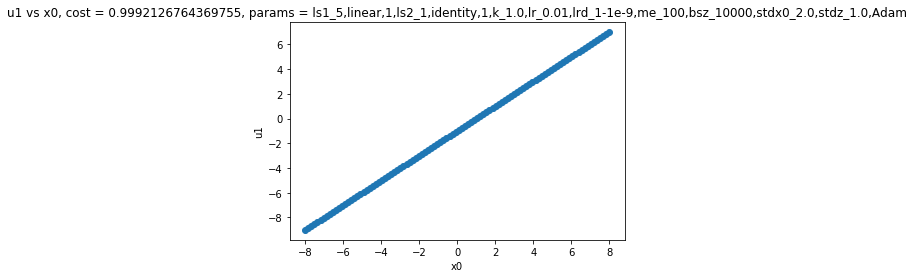

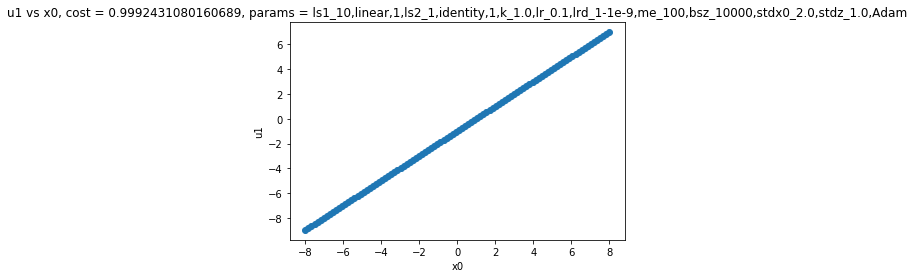

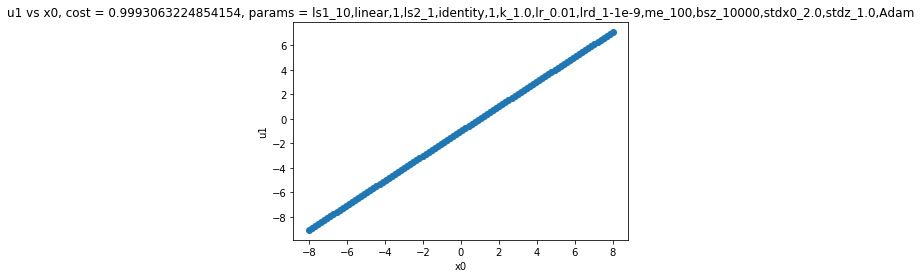

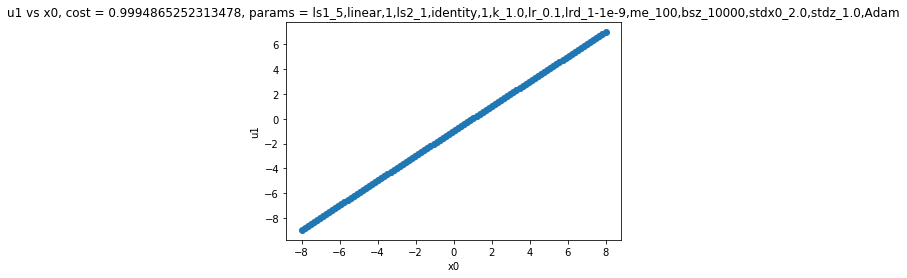

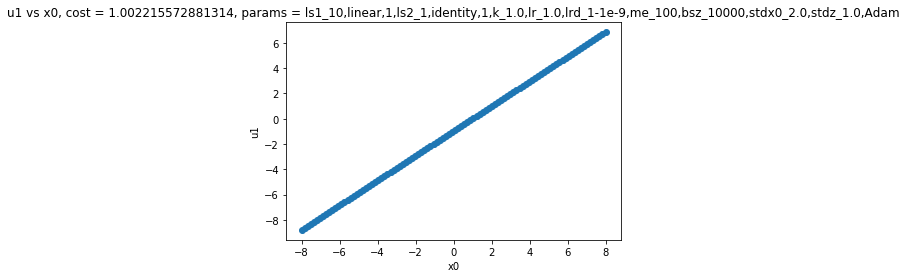

In [10]:
##############
#Process Results
##############
%matplotlib inline

hyperparam_results_list_sorted = sorted(hyperparam_results_list, key=lambda tup: tup[2])   

#Write results to file

if os.path.exists(FIGPATH) is False:
    os.system("mkdir " + FIGPATH)
top_results_file = RESULTSFILEPATH + UNIQUEID + '_top' + str(TOPK) + '.txt'
with open(top_results_file, 'w') as g:
    for k in range(min(TOPK,len(hyperparam_results_list))):
        tup_str = hyperparam_results_list_sorted[k][0]
        avg_test_cost = hyperparam_results_list_sorted[k][1]
        avg_test_cost_rep = hyperparam_results_list_sorted[k][2]
        g.write(tup_str + " " + str(avg_test_cost) + " " + str(avg_test_cost_rep) + '\n')
        
        x0_test_rep = hyperparam_results_list_sorted[k][3]
        u1_test_rep = hyperparam_results_list_sorted[k][4]
        
#         plt = f
        plt.close('all')
        plt.figure()
        plt.title('u1 vs x0, cost = ' + str(avg_test_cost_rep) + ', params = ' + tup_str)          
        plt.scatter(x0_test_rep, u1_test_rep)
        
        plt.xlabel('x0')
        plt.ylabel('u1')
        fig_path = FIGPATH + "/u1_vs_x0_" + tup_str + '.png'
        plt.savefig(fig_path, format = 'png')
        plt.show()
                   
    g.close()